In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm, t

class BSHelper:
    data: pd.DataFrame
    data_window_start: int
    data_window_end: int
    rolling_volatility_10d: dict = {'volatility': None, 'volstate': None}
    rolling_volatility_30d: dict = {'volatility': None, 'volstate': None}
    rolling_volatility_60d: dict = {'volatility': None, 'volstate': None}
    states: list
    
    def __init__(self, data: pd.DataFrame, nStates: int = 3):
        self.data = data
        self.data_window_start = 0
        self.data_window_end = len(data) - 1
        
        # Set states based on number of states
        if nStates > 10:
            raise ValueError("nStates should be less than or equal to 10")
        else:
            self.states = range(nStates)
        
        # Computing rolling volatility for different windows
        self.rolling_volatility_10d['volatility'] = self.rolling_volatility(window=10)
        self.rolling_volatility_30d['volatility'] = self.rolling_volatility(window=30)
        self.rolling_volatility_60d['volatility'] = self.rolling_volatility(window=60)
        
        # Determining volatility states and setting NaN values to 0
        self.qcut_volatility(self.rolling_volatility_10d, nStates)
        self.qcut_volatility(self.rolling_volatility_30d, nStates)
        self.qcut_volatility(self.rolling_volatility_60d, nStates)
    
    # Sets NaN values to 0 and categorizes volatility into states
    def qcut_volatility(self, volatility_dict: dict, nStates: int):
        volatility_dict['volatility'].fillna(0, inplace=True)
        volatility_dict['volstate'] = pd.qcut(volatility_dict['volatility'], q=nStates, labels=range(nStates))
    
    # Calculates rolling volatility based on the 'close' price
    def rolling_volatility(self, window: int = 10) -> pd.Series:
        """
        Calculate rolling volatility over a specified window.
        """
        return self.data['close'].rolling(window=window).std()
    
    # Sets the data window for analysis
    def set_data_window(self, start: int, end: int):
        self.data_window_start = start
        if end == -1:
            self.data_window_end = len(self.data) - 1
        else: 
            self.data_window_end = end
        
    # Returns the first n rows of the data window
    def head(self, n: int = 5) -> pd.DataFrame:
        return self.data.iloc[self.data_window_start:self.data_window_start + n]
    
    # Returns the last n rows of the data window
    def tail(self, n: int = 5) -> pd.DataFrame:
        return self.data.iloc[self.data_window_end - n:self.data_window_end + 1]
    
    def plot_volatility_regimes(self, volatility_dict, title, ylabel):
        state_colors = ['green', 'orange', 'red', 'yellow', 'blue', 'pink', 'gray', 'cyan', 'purple', 'brown']
        
        # state_colors = {i: colors[i % len(colors)] for i in range(len((self.states)))}
        
        dates = self.data.iloc[self.data_window_start:self.data_window_end+1]['timestamp']
        xindices = np.arange(self.data_window_start, self.data_window_end + 1, 1)
        volatility = volatility_dict['volatility'].iloc[self.data_window_start:self.data_window_end + 1]
        vol_state = volatility_dict['volstate'].iloc[self.data_window_start:self.data_window_end + 1]

        # Create a figure with two rows
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 6), sharex=True, height_ratios=[3, 1])

        # ----- Top plot: 10D Volatility Line -----
        ax1.plot(xindices, volatility, label='Volatility', color='blue', linewidth=1.5)

        # Axis formatting
        ax1.set_title(title, fontsize=14)
        ax1.set_ylabel(ylabel)
        ax1.legend(loc='upper left')
        # ax1.set_xticks(dates)
        # ax1.set_xticks(dates[::int(len(dates)/1000)])  # Show every 10th date

        # # ----- Bottom plot: VolState Step Plot -----
        ax2.step(xindices, vol_state, where='post', color='black', linewidth=1.2, label='Volatility Regime')

        # Y-axis: show labels like "Low", "Medium", "High"
        ax2.set_yticks(self.states)
        ax2.set_yticklabels(self.states)
        ax2.set_xlabel('Timestamp')
        ax2.set_ylabel('Regime')
        ax2.legend(loc='upper left')
        
        # Background shading by regime
        for i in range(len(vol_state) - 1):
            start = self.data_window_start+i
            end = self.data_window_start+i+1
            state = vol_state.iloc[i]
            ax1.axvspan(start, end, color=state_colors[state], alpha=0.1)
            ax2.axvspan(start, end, color=state_colors[state], alpha=0.1)

        # # X-axis formatting
        # ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        # fig.autofmt_xdate()

        return fig
    
    # Function to get the holding times and transitions
    def getHoldingTimesAndTransitions(self, vol_state: list, states=None):
        
        if states is None:
            states = self.states
            
        nStates = len(states)
        transitions = np.zeros((nStates, nStates))
        holding_times = np.zeros(nStates)

        for i in range(1, len(vol_state)):
            s_prev = vol_state[i-1]
            s_curr = vol_state.iloc[i]
            # delta_t = (df.iloc[i]['Date'] - df.iloc[i-1]['Date']).days # 1 day is the delta

            holding_times[s_prev] += 1
            if s_prev != s_curr:
                transitions[s_prev, s_curr] += 1
        
        return (holding_times, transitions)

    # Compute the Q Matrix
    def computeQMatrix(self, holding_times, transitions, states=None):
        if states is None:
            states = self.states
        nStates = len(states)
        Q = np.zeros((nStates, nStates))

        for i in range(nStates):
            for j in range(nStates):
                if i != j:
                    Q[i, j] = transitions[i, j] / holding_times[i]
            Q[i, i] = -np.sum(Q[i, :])
        
        return Q
    
    def simulate_ctmc(Q, states, start_state, time_horizon, nTrials=1):
        current_state = states.index(start_state)
        time = 0
        history = [(time, states[current_state])]

        while time < time_horizon:
            rate = -Q[current_state, current_state]
            time += np.random.exponential(1/rate)

            probs = (Q[current_state]/rate)
            probs[current_state] = 0 # No self-transition

            next_state = np.random.choice(range(len(states)), p=probs)

            current_state = next_state
            history.append((float(np.round(time,2)), states[current_state]))
        
        return history

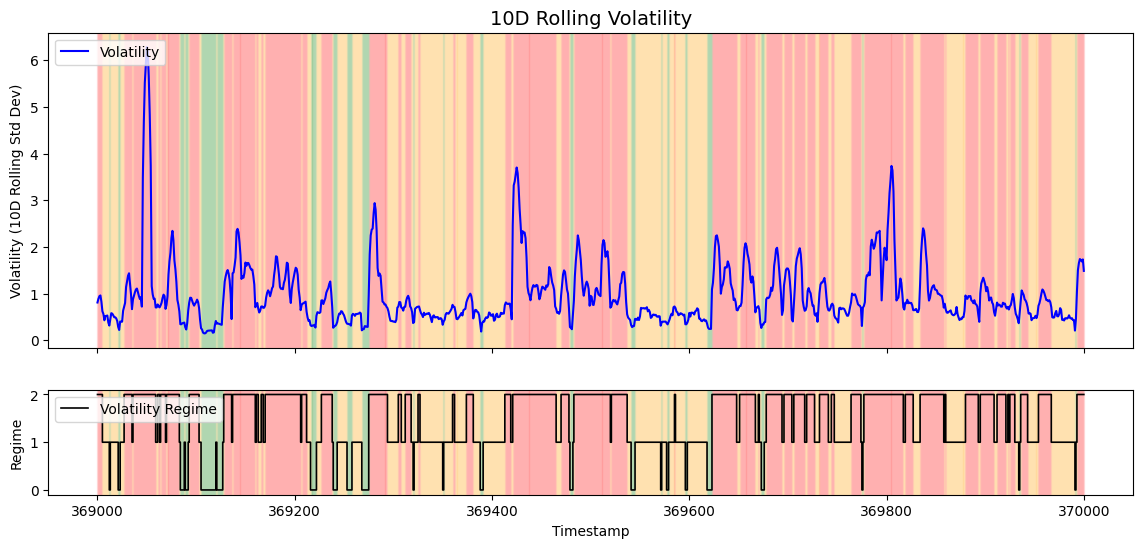

In [8]:
hdfc = pd.read_csv('/Users/shayak/lprogramsl/backtrading/HDFCBANK/HDFCBANK__EQ__NSE__NSE__MINUTE.csv')
hdfc['timestamp'] = pd.to_datetime(hdfc['timestamp'])
bsHelper = BSHelper(hdfc, nStates=3)
bsHelper.set_data_window(369000, 370000)

fig = bsHelper.plot_volatility_regimes(bsHelper.rolling_volatility_10d, '10D Rolling Volatility', 'Volatility (10D Rolling Std Dev)')


In [ ]:
# bsHelper.data.head()
bsHelper.rolling_volatility_10d['volstate']

10    2
11    2
12    2
13    1
14    0
15    0
16    0
17    1
18    1
19    1
Name: close, dtype: category
Categories (3, int64): [0 < 1 < 2]


[-0.00053452  0.00178063  0.00254672 ... -0.00014056 -0.00091411
  0.00137085]
NaN at index 37678, value: nan
NaN at index 37679, value: nan
NaN at index 37680, value: nan
NaN at index 55092, value: nan
NaN at index 55093, value: nan
(2.795759023340665, -4.754059702510839e-06, 0.0005964645690385754)


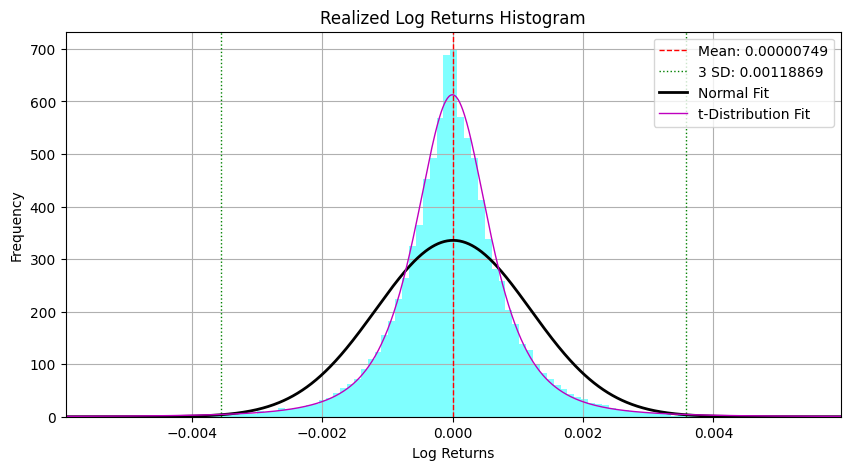

In [56]:
d1 = np.array(bsHelper.data.iloc[bsHelper.data_window_start:bsHelper.data_window_end]['close'])
d2 = np.array(bsHelper.data.iloc[bsHelper.data_window_start+1:bsHelper.data_window_end+1]['close'])
log_returns = np.log(d2 / d1)
print(log_returns)

for i in range(len(log_returns)):
    if np.isnan(log_returns[i]):
        print(f'NaN at index {i}, value: {log_returns[i]}')
        log_returns[i] = 0.0
        
lr_mean = np.mean(log_returns)
lr_std  = np.std(log_returns)


plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=1000, color='cyan', alpha=0.5, density=True)
plt.axvline(lr_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {lr_mean:.8f}')
plt.axvline(lr_mean + 3*lr_std, color='green', linestyle='dotted', linewidth=1, label=f'3 SD: {lr_std:.8f}')
plt.axvline(lr_mean - 3*lr_std, color='green', linestyle='dotted', linewidth=1)

# Fit a normal distribution to the log returns histogram
norm_params = norm.fit(log_returns)
mu, std = norm_params
x = np.linspace(lr_mean - 5*lr_std, lr_mean + 5*lr_std, 1000)
plt.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Fit')

# Fit a t-distribution to the log returns histogram
t_params = t.fit(log_returns)
print(t_params)
df_fitted, loc_fitted, scale_fitted = t_params
t_dist = t.pdf(x, df_fitted, loc=loc_fitted, scale=scale_fitted)
plt.plot(x, t_dist, 'm-', linewidth=1, label='t-Distribution Fit')

plt.title('Realized Log Returns Histogram')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(lr_mean - lr_std * 5, lr_mean + lr_std * 5)
plt.grid()
plt.show()

70321 70321
[-0.01356986 -0.01532505 -0.01855452 ... -0.00909542 -0.01053175
 -0.00849938]
NaN at index 37454, value: nan
NaN at index 37455, value: nan
NaN at index 37679, value: nan
NaN at index 37680, value: nan
NaN at index 54868, value: nan
NaN at index 55093, value: nan


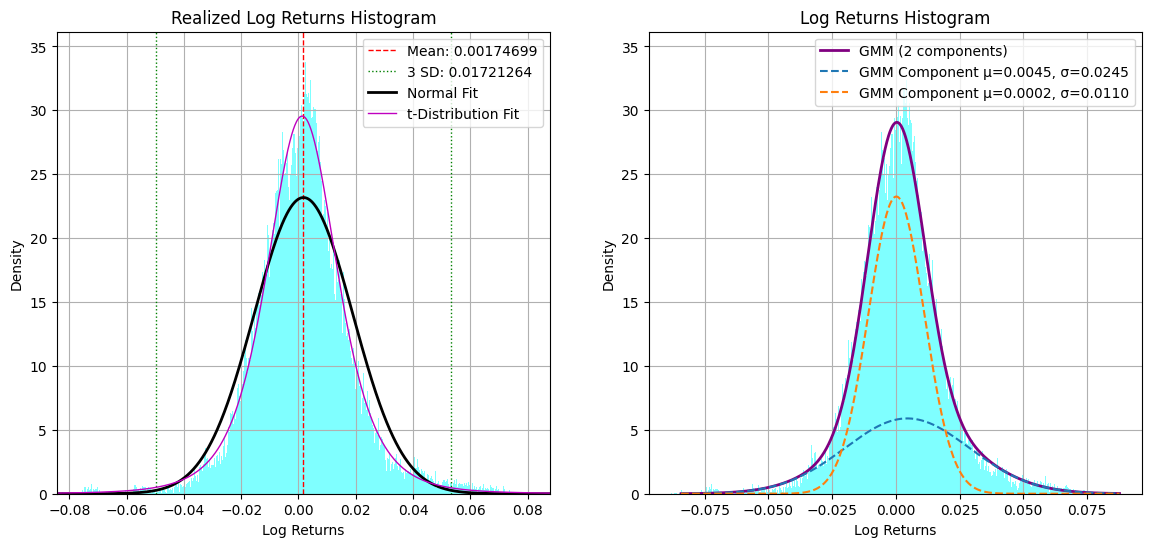

In [183]:
from scipy.stats import t, norm
from sklearn.mixture import GaussianMixture

time_period = 225
d1 = np.array(bsHelper.data.iloc[bsHelper.data_window_start:bsHelper.data_window_end - (time_period-1)]['close'])
d2 = np.array(bsHelper.data.iloc[bsHelper.data_window_start + (time_period) :bsHelper.data_window_end+1]['close'])
print(len(d1), len(d2))
log_returns = np.log(d2 / d1)
print(log_returns)

for i in range(len(log_returns)):
    if np.isnan(log_returns[i]):
        print(f'NaN at index {i}, value: {log_returns[i]}')
        log_returns[i] = 0.0
        
lr_mean = np.mean(log_returns)
lr_std  = np.std(log_returns)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=False, width_ratios=[1,1])

# Histogram and fits on ax1
ax1.hist(log_returns, bins=1000, color='cyan', alpha=0.5, density=True)
ax1.axvline(lr_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {lr_mean:.8f}')
ax1.axvline(lr_mean + 3*lr_std, color='green', linestyle='dotted', linewidth=1, label=f'3 SD: {lr_std:.8f}')
ax1.axvline(lr_mean - 3*lr_std, color='green', linestyle='dotted', linewidth=1)

# Fit a normal distribution to the log returns histogram
norm_params = norm.fit(log_returns)
mu, std = norm_params
x = np.linspace(lr_mean - 5*lr_std, lr_mean + 5*lr_std, 1000)
ax1.plot(x, norm.pdf(x, mu, std), 'k', linewidth=2, label='Normal Fit')

# Fit a t-distribution to the log returns histogram
t_params = t.fit(log_returns)
df_fitted, loc_fitted, scale_fitted = t_params
t_dist = t.pdf(x, df_fitted, loc=loc_fitted, scale=scale_fitted)
ax1.plot(x, t_dist, 'm-', linewidth=1, label='t-Distribution Fit')

ax1.set_title('Realized Log Returns Histogram')
ax1.set_xlabel('Log Returns')
ax1.set_ylabel('Density')
ax1.legend()
ax1.set_xlim(lr_mean - lr_std * 5, lr_mean + lr_std * 5)
ax1.grid()

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
log_returns_reshape = log_returns.reshape(-1, 1)
gmm.fit(log_returns_reshape)

# Predict the density over the same x range as the histogram
gmm_density = np.exp(gmm.score_samples(x.reshape(-1, 1)))
ax2.plot(x, gmm_density, color='purple', linewidth=2, label='GMM (2 components)')


# Plot the two normal distributions that make up the GMM
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_.flatten()

for mean, std, weight in zip(means, stds, weights):
    ax2.plot(x, weight * norm.pdf(x, mean, std), linewidth=1.5, label=f'GMM Component μ={mean:.4f}, σ={std:.4f}', linestyle='dashed')

ax2.legend()
ax2.hist(log_returns, bins=1000, color='cyan', alpha=0.5, density=True)
ax2.set_title('Log Returns Histogram')
ax2.set_xlabel('Log Returns')
ax2.set_ylabel('Density')
ax2.grid()


plt.show()

In [113]:
aapl_opts = pd.read_csv('/Users/shayak/lprogramsl/backtrading/dissertaion/AAPL_opts.csv')
aapl_opts['strike_price'] = aapl_opts['strike_price'].astype(float)/1000
aapl_opts[(aapl_opts['strike_price'] == 150) 
          & (aapl_opts['exdate'] == '30/09/2022')
          & (aapl_opts['cp_flag'] == 'C')].head(23)


,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,sic,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag
414,101594,01/09/2022,AAPL 220930C150000,1,30/09/2022,01/09/2022,C,150.0,10.90,11.05,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
918,101594,02/09/2022,AAPL 220930C150000,1,30/09/2022,02/09/2022,C,150.0,9.05,9.15,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
1438,101594,06/09/2022,AAPL 220930C150000,1,30/09/2022,06/09/2022,C,150.0,8.10,8.20,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
1974,101594,07/09/2022,AAPL 220930C150000,1,30/09/2022,07/09/2022,C,150.0,8.75,8.85,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
2392,101594,08/09/2022,AAPL 220930C150000,1,30/09/2022,08/09/2022,C,150.0,7.25,7.30,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
2922,101594,09/09/2022,AAPL 220930C150000,1,30/09/2022,09/09/2022,C,150.0,9.25,9.35,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
3452,101594,12/09/2022,AAPL 220930C150000,1,30/09/2022,12/09/2022,C,150.0,14.35,14.45,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
3982,101594,13/09/2022,AAPL 220930C150000,1,30/09/2022,13/09/2022,C,150.0,7.10,7.20,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
4512,101594,14/09/2022,AAPL 220930C150000,1,30/09/2022,14/09/2022,C,150.0,7.80,7.90,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN
4846,101594,15/09/2022,AAPL 220930C150000,1,30/09/2022,15/09/2022,C,150.0,5.75,5.80,...,3571,0,4,NaN,0,NaN,APPLE INC,NaN,A,NaN


In [142]:
aapl = pd.read_csv('/Users/shayak/lprogramsl/backtrading/dissertaion/AAPL.csv')
aapl[['date', 'close']].head()

,date,close
0,2022-09-01,157.96
1,2022-09-02,155.81
2,2022-09-06,154.53
3,2022-09-07,155.96
4,2022-09-08,154.46


In [152]:
def black_scholes(St, K, r, T, t, sigma):
    time = (T-t)/252
    d1 = (np.log(St / K) + (r + 0.5 * sigma**2) * time) / (sigma * np.sqrt(time))
    d2 = d1 - sigma * np.sqrt(time)

    calculated_call_price = St * norm.cdf(d1) - K * np.exp(-r * time) * norm.cdf(d2)
    
    return calculated_call_price

bid = 58.15
ask = 58.4
call_price = (bid + ask) / 2
St = 157.96
K = 100
r = 3.125 * 0.01
T = 30
t = 1
sigma = 0.343981

calculated_call_price = black_scholes(St, K, r, T, t, sigma)


print(call_price, calculated_call_price)

58.275 58.31910812227828


In [153]:
df = aapl_opts[ (aapl_opts['date'] == '01/09/2022')
          & (aapl_opts['exdate'] == '30/09/2022')
          & (aapl_opts['cp_flag'] == 'C')]
# df.head()
oprices = df.iloc[0:3][['strike_price', 'best_bid', 'best_offer', 'impl_volatility']]
# oprices

for i in range(len(oprices)):
    K = oprices.iloc[i]['strike_price']
    sigma = oprices.iloc[i]['impl_volatility']
    calculated_call_price = black_scholes(St, K, r, T, t, sigma)
    
    call_price = (oprices.iloc[i]['best_bid'] + oprices.iloc[i]['best_offer'])/2
    print(f'Call Price: {call_price}, Calculated Call Price: {calculated_call_price}')

Call Price: 58.275, Calculated Call Price: 58.67751976666132
Call Price: 53.325, Calculated Call Price: 53.78584715943336
Call Price: 48.35, Calculated Call Price: 48.827698939175974


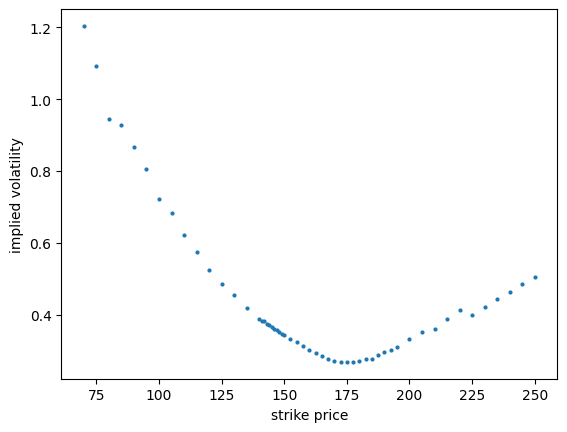

In [154]:
x = df['strike_price']
y = df['impl_volatility']

# plot x and y
plt.plot(x, y, 'o', markersize=2)
plt.ylabel('implied volatility')
plt.xlabel('strike price')
plt.show()

In [9]:
import numpy as np

rnv = np.random.normal(loc=0, scale=1, size=(100_000_000,))
rnv

array([ 1.02167127,  0.65538612, -0.96978291, ..., -0.63573362,
        0.12677327, -0.57453981])

In [12]:
rna = np.array([])
for i in range(0, 100_000_000):
    val = (np.random.normal(loc=0, scale=1))
    rna.__add__(val)

rna

KeyboardInterrupt: 